# IEEE CIS Fraud Detection

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from collections import defaultdict
import gc


# data preparation
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix

# algorithms
from sklearn import linear_model, ensemble
import xgboost as xgb

# evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, average_precision_score, classification_report
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, f1_score

import warnings
warnings.filterwarnings('ignore')


## Setting-up GPU memory utilization

In [2]:
# making sure colab uses GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=b79e678eb41fecc99c34d151a7f47804925947701538f168beb2e9ce27d6c720
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.1 GB  | Proc size: 588.0 MB
GPU RAM Free: 16015MB | Used: 265MB | Util   2% | Total 16280MB


## Importing data from Kaggle API into Google Colab

In [1]:
# import json file into colab
from google.colab import files
files.upload()

# setup Kaggle DIR; copy json file ; chmod
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle//
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

# verifying json file content
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
kaggle.json
total 4
-rw------- 1 root root 64 Dec  9 04:53 kaggle.json
{"username":"hafeez13","key":"f8f4ff99e0d6a812fd6a8fc27d6238d4"}

In [2]:
# Kaggle datasets list related to Amazon
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2272           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      16943            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       5502            True  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         57           False  
competitive-data-science-predict-future-sales  2020-12-31 23:59:00  Playground           Kudos       5077           False  
google-quest-challenge                         2020-02-10 23:59:00  Featured           $25,000        422           False  
tensorfl

In [3]:
# download the dataset
!kaggle competitions download ieee-fraud-detection

# unzip files
!unzip \*.zip

 63% 33.0M/52.5M [00:00<00:00, 63.2MB/s]
100% 52.5M/52.5M [00:00<00:00, 97.5MB/s]
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 100MB/s]
 89% 42.0M/47.3M [00:00<00:00, 67.2MB/s]
100% 47.3M/47.3M [00:00<00:00, 136MB/s] 
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 98.2MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 160MB/s]
Archive:  train_identity.csv.zip
  inflating: train_identity.csv      

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  test_transaction.csv.zip
  inflating: test_transaction.csv    

Archive:  test_identity.csv.zip
  inflating: test_identity.csv       

Archive:  train_transaction.csv.zip
  inflating: train_transaction.csv   

5 archives were successfully processed.


In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

## Loading Dataset

In [0]:
train_trans = pd.read_csv('train_transaction.csv')
train_id = pd.read_csv('train_identity.csv')

#loading test sets
test_trans = pd.read_csv('test_transaction.csv')
test_id = pd.read_csv('test_identity.csv')

#merging train sets into a single train dataset
train_df = pd.merge(train_trans, train_id, on = 'TransactionID', how = 'left')

#merging test sets into a single test dataset
test_df = pd.merge(test_trans, test_id, on = 'TransactionID', how  = 'left')

## Memory Reduction

In [0]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 1959.88 MB --> 650.48 MB (Decreased by 66.8%)
Memory usage of dataframe is 1677.73 MB --> 565.37 MB (Decreased by 66.3%)


In [9]:
print('Train size: ', train_df.shape)
print('Test size: ', test_df.shape)

Train size:  (590540, 434)
Test size:  (506691, 433)


In [0]:
del train_id, train_trans, test_id, test_trans
gc.collect()

0

# Data Exploration (EDA/VEDA)

In [0]:
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float16(354), float32(45), int16(1), int32(2), int8(1), object(31)
memory usage: 650.5+ MB


In [0]:
train_df.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,238269.0,37627.0,590540.0,590540.0,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,589271.0,309743.0,327662.0,421618.0,280699.0,73187.0,38917.0,74926.000000,74926.000000,514518.0,311253.0,64717.0,61952.0,62187.0,...,82351.0,82351.0,82351.000000,82351.0,82351.000000,82351.000000,82351.0,82351.000000,82351.000000,82351.000000,82351.000000,82351.0,82351.0,82351.0,82351.000000,82351.000000,82351.000000,144233.0,140872.0000,66324.000000,66324.000000,136865.0,136865.0,5155.000000,5155.000000,74926.000000,74926.000000,140978.0,127320.0,80044.0,139369.0,4.511300e+04,139318.0,139261.0,5159.0,5169.000000,4747.000000,5132.0000,5163.00000,77586.0
mean,3.282270e+06,0.034990,7.372311e+06,NaN,9898.734658,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN,0.005650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,0.560059,NaN,NaN,inf,inf,inf,...,NaN,NaN,0.058624,NaN,0.296387,0.336914,NaN,0.775391,721.741455,1375.778564,1014.619934,NaN,NaN,NaN,55.352417,151.160538,100.700874,NaN,174716.9375,0.060089,-0.059052,NaN,NaN,inf,-inf,0.091187,-0.301025,NaN,NaN,NaN,NaN,inf,NaN,NaN,inf,inf,12.820312,inf,inf,NaN
std,1.704744e+05,0.183755,4.617224e+06,NaN,4901.170153,NaN,0.0,0.0,NaN,0.0,NaN,inf,NaN,NaN,0.150635,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,0.316650,NaN,NaN,inf,inf,inf,...,NaN,NaN,0.304443,0.0,0.000000,0.000000,0.0,0.000000,6217.229980,11169.515625,7955.782227,NaN,NaN,NaN,668.375854,1095.057739,814.953247,0.0,159650.0000,0.598145,0.701172,0.0,0.0,11.382812,26.078125,0.000000,0.000000,0.0,0.0,NaN,0.0,1.561523e+00,NaN,NaN,inf,6.898438,2.373047,97.4375,32.09375,0.0
min,2.987000e+06,0.000000,8.640000e+04,0.250977,1000.000000,100.0,100.0,100.0,100.0,10.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-122.0,0.0,-83.0,0.0,0.000000,0.000000,0.0,-53.0,-83.0,0.0,-193.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,-100.0,1.0000,-13.000000,-28.000000,-72.0,-100.0,-46.000000,-100.000000,-36.000000,-100.000000,90.0,10.0,-660.0,100.0,1.000000e+01,100.0,100.0,100.0,10.000000,11.000000,100.0000,100.00000,0.0
25%,3.134635e+06,0.000000,3.027058e+06,43.312500,6019.000000,214.0,150.0,166.0,204.0,87.0,3.0,7.0,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,26.0,1.0,0.0,1.0,0.0,0.0,0.958496,0.208374,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,-10.0,67992.0000,0.000000,0.000000,0.0,-6.0,5.000000,-48.000000,0.000000,0.000000,100.0,49.0,-360.0,166.0,1.300000e+01,266.0,256.0,252.0,14.000000,11.000000,321.0000,119.00000,24.0
50%,3.282270e+06,0.000000,7.306528e+06,68.750000,9678.000000,361.0,150.0,226.0,299.0,87.0,8.0,37.0,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0,3.0,97.0,8.0,26.0,10.0,0.0,0.0,37.875000,0.666504,15.0,43.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,-5.0,125800.5000,0.000000,0.000000,0.0,0.0,14.000000,-34.000000,0.000000,0.000000,100.0,52.0,-300.0,166.0,1.500000e+01,341.0,472.0,252.0,14.000000,11.000000,321.0000,149.00000,24.0
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.0,150.0,226.0,330.0,87.0,24.0,206.0,3.0,3.0,0.000000,0.0,1.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,12.0,2.0

In [0]:
test_df.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2636.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# how many categorical variables
cols = train_df.columns
num_cols = train_df._get_numeric_data().columns
print('Categorical columns {}'.format(set(cols) - set(num_cols)))
print("Number of categorical columns: ", len(set(cols)-set(num_cols)))

Categorical columns {'P_emaildomain', 'M6', 'id_34', 'M4', 'R_emaildomain', 'id_35', 'DeviceType', 'id_12', 'M7', 'id_23', 'M5', 'id_31', 'id_16', 'card6', 'DeviceInfo', 'id_15', 'M9', 'M1', 'id_37', 'M8', 'card4', 'id_38', 'M3', 'id_30', 'M2', 'id_33', 'id_29', 'id_36', 'id_28', 'ProductCD', 'id_27'}
Number of categorical columns:  31


In [0]:
train_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

ProductCD           5
card4               4
card6               4
P_emaildomain      59
R_emaildomain      60
M1                  2
M2                  2
M3                  2
M4                  3
M5                  2
M6                  2
M7                  2
M8                  2
M9                  2
id_12               2
id_15               3
id_16               2
id_23               3
id_27               2
id_28               2
id_29               2
id_30              75
id_31             130
id_33             260
id_34               4
id_35               2
id_36               2
id_37               2
id_38               2
DeviceType          2
DeviceInfo       1786
dtype: int64

In [0]:
test_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

ProductCD           5
card4               4
card6               3
P_emaildomain      60
R_emaildomain      60
M1                  2
M2                  2
M3                  2
M4                  3
M5                  2
M6                  2
M7                  2
M8                  2
M9                  2
id_12               2
id_15               3
id_16               2
id_23               3
id_27               2
id_28               2
id_29               2
id_30              86
id_31             135
id_33             390
id_34               2
id_35               2
id_36               2
id_37               2
id_38               2
DeviceType          2
DeviceInfo       2226
dtype: int64

### Target Distribution

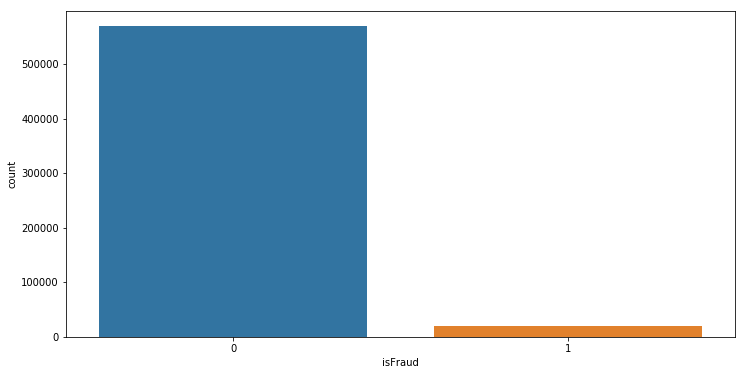

In [0]:
plt.figure(figsize = (12,6))
_ = sns.countplot(train_df.isFraud)
plt.show()

### Correlation with Fraud

In [11]:
fraud_corr = train_df.corr()['isFraud'].sort_values()
print('most negative correlations: ', fraud_corr.head(10))
print('most positive correlations: ', fraud_corr.tail(10))

most negative correlations:  D8      -0.142634
D7      -0.127199
id_01   -0.120099
V48     -0.115786
V49     -0.110920
V90     -0.110168
V29     -0.107852
V91     -0.105453
V69     -0.104521
V30     -0.103088
Name: isFraud, dtype: float64
most positive correlations:  V258       0.297151
V188       0.303582
V189       0.308219
V200       0.318783
V201       0.328005
V242       0.360590
V244       0.364129
V246       0.366878
V257       0.383060
isFraud    1.000000
Name: isFraud, dtype: float64


### Fraud Transcation Min, Max and Average

In [0]:
min_fraud = min(train_df[train_df.isFraud == 1]['TransactionAmt'])
max_fraud = max(train_df[train_df.isFraud == 1]['TransactionAmt'])
mean_fraud = train_df[train_df.isFraud == 1]['TransactionAmt'].mean()

print('Minimum fraud amount: ', min_fraud)
print('Maximum fraud amount: ', max_fraud)
print('Mean fraud amount: ', mean_fraud)

Minimum fraud amount:  0.2919921875
Maximum fraud amount:  5192.0
Mean fraud amount:  inf


### Fraud Transaction Card Issuer, Card Type, Device Type

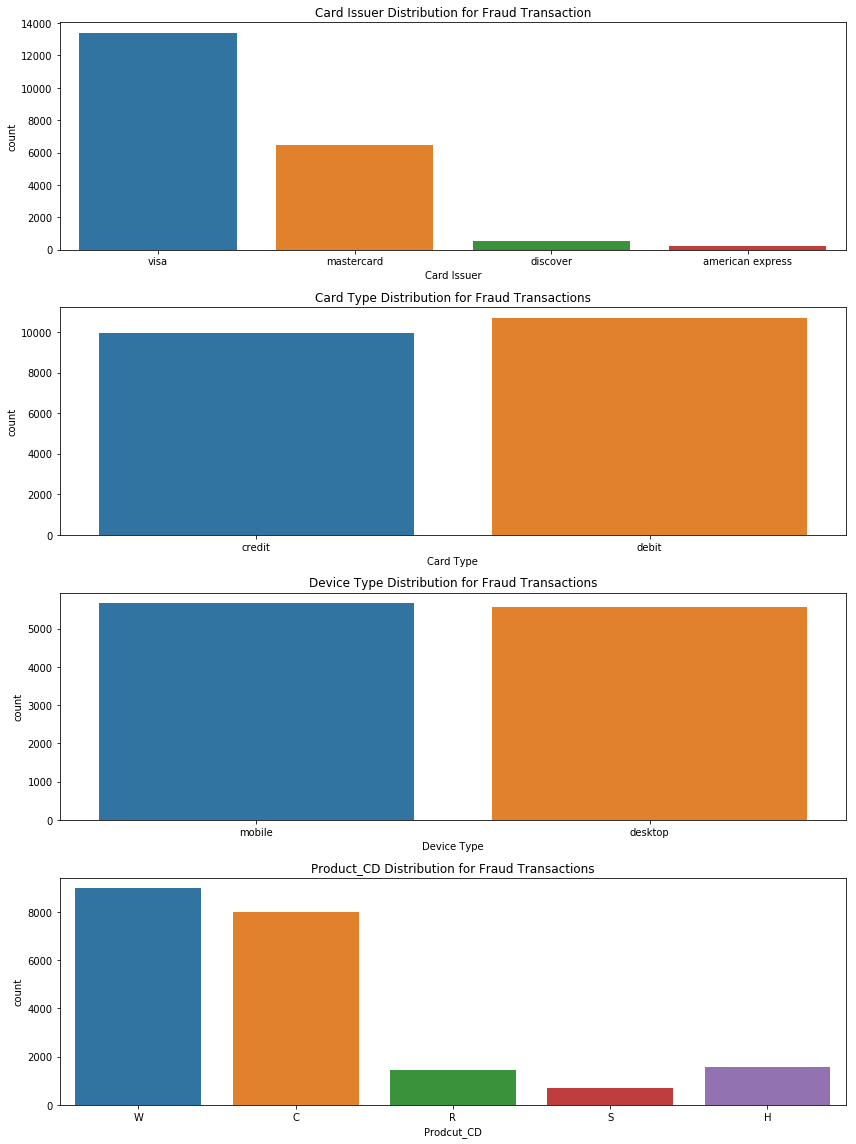

In [0]:
card_issuer = train_df[train_df.isFraud == 1]['card4']
card_type = train_df[train_df.isFraud == 1]['card6']
device_type = train_df[train_df.isFraud == 1]['DeviceType']
product_cd = train_df[train_df.isFraud == 1]['ProductCD']


plt.figure(figsize = (12,16))

plt.subplot(4,1,1)
_ = sns.countplot(card_issuer)
_.set_title('Card Issuer Distribution for Fraud Transaction')
_.set_xlabel('Card Issuer')

plt.subplot(4,1,2)
_ = sns.countplot(card_type)
_.set_title('Card Type Distribution for Fraud Transactions')
_.set_xlabel('Card Type')

plt.subplot(4,1,3)
_ = sns.countplot(device_type)
_.set_title('Device Type Distribution for Fraud Transactions')
_.set_xlabel('Device Type')

plt.subplot(4,1,4)
_ = sns.countplot(product_cd)
_.set_title('Product_CD Distribution for Fraud Transactions')
_.set_xlabel('Prodcut_CD')
plt.tight_layout()
plt.show()

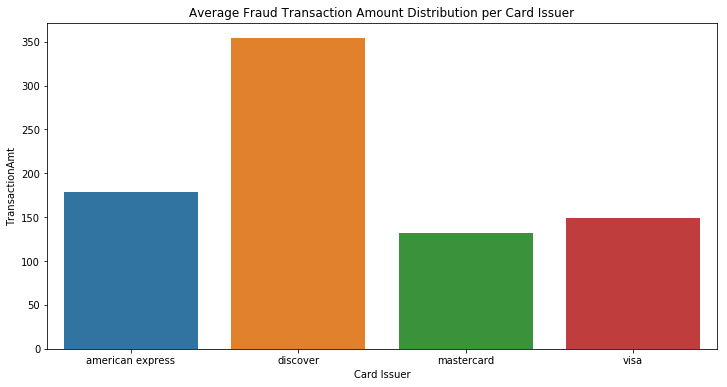

In [0]:
# average fraud transaction amount per card issuer
avg_fraud_amount = train_df[['TransactionAmt', 'card4']][train_df['isFraud'] == 1].groupby(by = 'card4').mean().reset_index()


plt.figure(figsize = (12,6))

_ = sns.barplot(x = "card4", y = "TransactionAmt", data = avg_fraud_amount)
_.set_title('Average Fraud Transaction Amount Distribution per Card Issuer')
_.set_xlabel('Card Issuer')

plt.show()

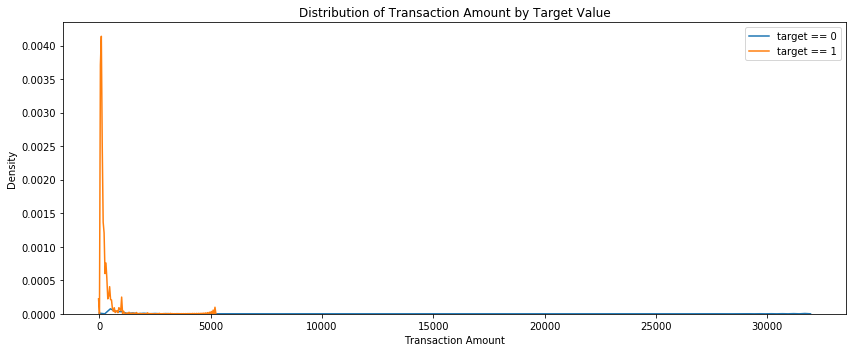

In [0]:
# create a new subplot for transaction amount per target class
plt.figure(figsize = (12,5))

# plot non-fraud transactions
_ = sns.kdeplot(train_df.loc[train_df['isFraud'] == 0, 'TransactionAmt'], label = 'target == 0')
# plot fraud transactions
_ = sns.kdeplot(train_df.loc[train_df['isFraud'] == 1, 'TransactionAmt'], label = 'target == 1')
    
# Label the plots
_.set_title('Distribution of %s by Target Value' % 'Transaction Amount')
_.set_xlabel('%s' % 'Transaction Amount')
_.set_ylabel('Density')
    
plt.tight_layout(h_pad = 2.5)
plt.show()

# Feature Engineering

### Meta features: Numeric

In [0]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    
    # First calculate counts
    counts = pd.DataFrame(df.groupby(group_var, as_index = False)[df.columns[1]].count()).rename(columns = {df.columns[1]: '%s_counts' % df_name})
    
    # Group by the specified variable and calculate the statistics
    agg = df.groupby(group_var).agg(['mean', 'max', 'min', 'sum']).reset_index()
    
    # Need to create new column names
    columns = [group_var]
    
    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
              
    #  Rename the columns
    agg.columns = columns
    
    # Merge with the counts
    agg = agg.merge(counts, on = group_var, how = 'left')
    
    return agg

In [11]:
tr_df = agg_numeric(train_df.drop(columns = ['isFraud', 'TransactionDT']), group_var = 'TransactionID', df_name = 'meta' )
tst_df = agg_numeric(test_df.drop(columns = ['TransactionDT']), group_var = 'TransactionID', df_name = 'meta')

print(tr_df.shape)
print(tst_df.shape)

(590540, 1602)
(506691, 1602)


In [12]:
tr_df.head()

,TransactionID,meta_TransactionAmt_mean,meta_TransactionAmt_max,meta_TransactionAmt_min,meta_TransactionAmt_sum,meta_card1_mean,meta_card1_max,meta_card1_min,meta_card1_sum,meta_card2_mean,meta_card2_max,meta_card2_min,meta_card2_sum,meta_card3_mean,meta_card3_max,meta_card3_min,meta_card3_sum,meta_card5_mean,meta_card5_max,meta_card5_min,meta_card5_sum,meta_addr1_mean,meta_addr1_max,meta_addr1_min,meta_addr1_sum,meta_addr2_mean,meta_addr2_max,meta_addr2_min,meta_addr2_sum,meta_dist1_mean,meta_dist1_max,meta_dist1_min,meta_dist1_sum,meta_dist2_mean,meta_dist2_max,meta_dist2_min,meta_dist2_sum,meta_C1_mean,meta_C1_max,meta_C1_min,...,meta_id_17_max,meta_id_17_min,meta_id_17_sum,meta_id_18_mean,meta_id_18_max,meta_id_18_min,meta_id_18_sum,meta_id_19_mean,meta_id_19_max,meta_id_19_min,meta_id_19_sum,meta_id_20_mean,meta_id_20_max,meta_id_20_min,meta_id_20_sum,meta_id_21_mean,meta_id_21_max,meta_id_21_min,meta_id_21_sum,meta_id_22_mean,meta_id_22_max,meta_id_22_min,meta_id_22_sum,meta_id_24_mean,meta_id_24_max,meta_id_24_min,meta_id_24_sum,meta_id_25_mean,meta_id_25_max,meta_id_25_min,meta_id_25_sum,meta_id_26_mean,meta_id_26_max,meta_id_26_min,meta_id_26_sum,meta_id_32_mean,meta_id_32_max,meta_id_32_min,meta_id_32_sum,meta_counts
0,2987000,68.5,68.5,68.5,68.5,13926,13926,13926,13926,NaN,NaN,NaN,0.0,150.0,150.0,150.0,150.0,142.0,142.0,142.0,142.0,315.0,315.0,315.0,315.0,87.0,87.0,87.0,87.0,19.0,19.0,19.0,19.0,NaN,NaN,NaN,0.0,1.0,1.0,1.0,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,1
1,2987001,29.0,29.0,29.0,29.0,2755,2755,2755,2755,404.0,404.0,404.0,404.0,150.0,150.0,150.0,150.0,102.0,102.0,102.0,102.0,325.0,325.0,325.0,325.0,87.0,87.0,87.0,87.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,1.0,1.0,1.0,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,1
2,2987002,59.0,59.0,59.0,59.0,4663,4663,4663,4663,490.0,490.0,490.0,490.0,150.0,150.0,150.0,150.0,166.0,166.0,166.0,166.0,330.0,330.0,330.0,330.0,87.0,87.0,87.0,87.0,287.0,287.0,287.0,287.0,NaN,NaN,NaN,0.0,1.0,1.0,1.0,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,1
3,2987003,50.0,50.0,50.0,50.0,18132,18132,18132,18132,567.0,567.0,567.0,567.0,150.0,150.0,150.0,150.0,117.0,117.0,117.0,117.0,476.0,476.0,476.0,476.0,87.0,87.0,87.0,87.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,2.0,2.0,2.0,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,1
4,2987004,50.0,50.0,50.0,50.0,4497,4497,4497,4497,514.0,514.0,514.0,514.0,150.0,150.0,150.0,150.0,102.0,102.0,102.0,102.0,420.0,420.0,420.0,420.0,87.0,87.0,87.0,87.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,1.0,1.0,1.0,...,166.0,166.0,166.0,NaN,NaN,NaN,0.0,542.0,542.0,542.0,542.0,144.0,144.0,144.0,144.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,32.0,32.0,32.0,32.0,1


## Categorical Features

In [0]:
# label encoding
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder


def cat_encode(train,test):
    for col in train.drop(['TransactionID','isFraud','TransactionDT'], axis = 1).columns:
        if train[col].dtype == 'O' or test[col].dtype == 'O':
            le = LabelEncoder() 
            le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
            train[col] = le.transform(list(train[col].astype(str).values))
            test[col] = le.transform(list(test[col].astype(str).values))
    return train,test

In [14]:
train = train_df.merge(tr_df, on = "TransactionID", how = 'left')
print("Number of features: ", train_df.shape[1])
print('Number of features after feature engineering: ', len(list(train.columns)))

Number of features:  434
Number of features after feature engineering:  2035


In [15]:
test = test_df.merge(tst_df, on = "TransactionID", how = 'left')
print("Number of features: ", test_df.shape[1])
print('Number of features after feature engineering: ', len(list(test.columns)))

Number of features:  433
Number of features after feature engineering:  2034


In [16]:
train, test = cat_encode(train, test)

print(train.shape)
print(test.shape)


(590540, 2035)
(506691, 2034)


In [0]:
train.isFraud.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

# Data Preparation

## Handling Missing Values

In [0]:
def missing_values_table(df):
        # Total missing values
        total_miss = df.isnull().sum()
        
        # Percentage of missing values
        miss_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        miss_val_table = pd.concat([total_miss, miss_val_percent], axis=1)
        
        # Rename the columns
        miss_val_table_ren_cols = miss_val_table.rename(
                                                    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        miss_val_table_ren_cols = miss_val_table_ren_cols[
                                                    miss_val_table_ren_cols.iloc[:,1] != 0].sort_values(
                                                                                                '% of Total Values', ascending=False).round(3)
        
        # Print some summary information
        print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(miss_val_table_ren_cols.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return miss_val_table_ren_cols

In [18]:
missing_train = missing_values_table(train)
missing_train.head(10)

Dataframe has 2035 columns.
There are 1536 columns that have missing values.


,Missing Values,% of Total Values
meta_id_24_max,585793,99.196
id_24,585793,99.196
meta_id_24_mean,585793,99.196
meta_id_24_min,585793,99.196
id_25,585408,99.131
meta_id_25_min,585408,99.131
meta_id_25_max,585408,99.131
meta_id_25_mean,585408,99.131
id_08,585385,99.127
id_07,585385,99.127


In [19]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

40

In [20]:
missing_test = missing_values_table(test)
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

Dataframe has 2034 columns.
There are 1420 columns that have missing values.


32

In [21]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

There are 40 columns with more than 90% missing in either the training or testing data.


In [22]:
# columns with majority missing values
majority_null_cols_train = [col for col in train.columns if train[col].isnull().sum()/train.shape[0] > 0.9]
majority_null_cols_test = [col for col in test.columns if test[col].isnull().sum()/test.shape[0] > 0.9]

# columns with the frequency less than 0.1
big_top_value_cols_train = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test  = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

# columns to drop except target variable
cols_to_drop = list(set(majority_null_cols_train + majority_null_cols_test + big_top_value_cols_train + big_top_value_cols_test))
cols_to_drop.remove('isFraud')

len(cols_to_drop)

512

In [0]:
# dorp missing columns 
train = train.drop(cols_to_drop, axis = 1)
test = test.drop(cols_to_drop, axis = 1)

In [24]:
missing_values_table(train)

Dataframe has 1523 columns.
There are 1220 columns that have missing values.


,Missing Values,% of Total Values
D13,528588,89.509
meta_D13_min,528588,89.509
meta_D13_max,528588,89.509
meta_D13_mean,528588,89.509
meta_D14_mean,528353,89.469
...,...,...
meta_V307_mean,12,0.002
meta_V306_min,12,0.002
meta_V306_max,12,0.002
meta_V306_mean,12,0.002


In [0]:
# fill missing values
train = train.fillna(-999)
test = test.fillna(-999)

In [26]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,...,meta_id_05_mean,meta_id_05_max,meta_id_05_min,meta_id_06_mean,meta_id_06_max,meta_id_06_min,meta_id_09_mean,meta_id_09_max,meta_id_09_min,meta_id_10_mean,meta_id_10_max,meta_id_10_min,meta_id_11_mean,meta_id_11_max,meta_id_11_min,meta_id_11_sum,meta_id_13_mean,meta_id_13_max,meta_id_13_min,meta_id_13_sum,meta_id_14_mean,meta_id_14_max,meta_id_14_min,meta_id_14_sum,meta_id_17_mean,meta_id_17_max,meta_id_17_min,meta_id_17_sum,meta_id_19_mean,meta_id_19_max,meta_id_19_min,meta_id_19_sum,meta_id_20_mean,meta_id_20_max,meta_id_20_min,meta_id_20_sum,meta_id_32_mean,meta_id_32_max,meta_id_32_min,meta_id_32_sum
0,2987000,0,86400,68.5,4,13926,-999.0,150.0,1,142.0,1,315.0,87.0,19.0,32,32,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,-999.0,13.0,-999.0,-999.0,-999.0,-999.0,-999.0,13.0,13.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0
1,2987001,0,86401,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,-999.0,16,32,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0
2,2987002,0,86469,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,87.0,287.0,36,32,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,0.0,315.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0
3,2987003,0,86499,50.0,4,18132,567.0,150.0,2,117.0,2,476.0,87.0,-999.0,55,32,2.0,5.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,-999.0,-999.0,-999.0,84.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0
4,2987004,0,86506,50.0,1,4497,514.0,150.0,2,102.0,1,420.0,87.0,-999.0,16,32,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,100.0,100.0,100.0,100.0,-999.0,-999.0,-999.0,0.0,-480.0,-480.0,-480.0,-480.0,166.0,166.0,166.0,166.0,542.0,542.0,542.0,542.0,144.0,144.0,144.0,144.0,32.0,32.0,32.0,32.0


## Collinearity

In [27]:
corrs = train.corr()

corrs = corrs.sort_values('isFraud', ascending = False)
pd.DataFrame(corrs['isFraud'].head(10))

,isFraud
isFraud,1.000000
meta_V257_sum,0.281349
meta_V201_sum,0.268686
meta_V246_sum,0.266292
meta_V200_sum,0.262079
meta_V244_sum,0.246454
meta_V189_sum,0.245846
meta_V242_sum,0.241799
meta_V258_sum,0.239206
meta_V188_sum,0.237794


## Removing collinear variables

In [0]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [30]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  1438


In [31]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (590540, 85)
Testing Corrs Removed Shape:  (506691, 84)


In [0]:
train_corrs_removed.to_csv('ieee_train_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('ieee_test_corrs_removed.csv', index = False)

In [33]:
gc.collect()

0